In [191]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io
import pandas as pd
from pygrowthmodels import vonbertalanffy
import scipy

# TODO:
    suavizar aneis
    confirmar se perfis estao bem traçados

In [62]:
dados = pd.DataFrame()
# importa nome dos ficheiros
lista = []
for file in os.listdir('photos/bios'):
    lista.append(file)
dados['file'] = lista
# extrai atributos dos ficheiros com base nos nomes
res = []
for name in dados['file']:
    res.append(name.split('-'))

dados['Lt'] = [item[5] for item in res]
dados['month'] = [item[3][2:5] for item in res]
# prepara idades
dados['age'] = 0
#limpeza
del lista, res

In [63]:
print(dados)

                                             file    Lt month  age
0       GUU-Deneb-Amo2-21Jan08-100-25,4-2-0,5.jpg  25,4   Jan    0
1       GUU-Deneb-Amo2-21Jan08-101-25,2-2-0,5.jpg  25,2   Jan    0
2         GUU-Deneb-Amo2-21Jan08-102-25-2-0,5.jpg    25   Jan    0
3       GUU-Deneb-Amo2-21Jan08-103-26,1-2-0,5.jpg  26,1   Jan    0
4     GUU-Deneb-Amo2-21Jan08-104-26,2-1,6-0,5.jpg  26,2   Jan    0
..                                            ...   ...   ...  ...
696  GUU-MardeLagos-Amo1-07Jan08-5-21,7-2-0,5.jpg  21,7   Jan    0
697  GUU-MardeLagos-Amo1-07Jan08-6-21,9-2-0,5.jpg  21,9   Jan    0
698  GUU-MardeLagos-Amo1-07Jan08-7-21,3-2-0,5.jpg  21,3   Jan    0
699  GUU-MardeLagos-Amo1-07Jan08-8-21,6-2-0,5.jpg  21,6   Jan    0
700  GUU-MardeLagos-Amo1-07Jan08-9-21,5-2-0,5.jpg  21,5   Jan    0

[701 rows x 4 columns]


In [7]:
teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')
teste_04 = io.imread('photos/NOVAS FOTOS/0004.tif', plugin='pil')
teste_05 = io.imread('photos/bios/GUU-Deneb-Amo2-21Jan08-49-20,9-2-0,5.jpg')


# Função: Prototipo 1:

In [122]:
def processador(imagem, plot:bool=True):
    colapsado = skimage.color.rgb2gray(imagem)

    # prepara histograma para desenhar imagem
    histogram, bin_edges = np.histogram(colapsado, bins=100, range=(0, 1))

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)

    # limpeza do segmentation edge
    mascara = segmentation_edge-1

    # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]
    otolito = skimage.color.label2rgb(labeled, mascara)

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel?
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # calcula extremo do rostro
    origin_x, origin_y = px[1], px[0]
    res = []
    for array in borda:
        for line in array:
            res.append(line.tolist())

    distancia = []
    for item in res:
        distancia.append(np.sqrt((origin_y-item[1])**2 + (origin_x-item[0])**2))
    max_index = distancia.index(max(distancia))
    extremo = res[max_index]

    # linha de perfil a partir do centroide
    profile = skimage.measure.profile_line(colapsado, src = (origin_y, origin_x), dst = (extremo[0],extremo[1]))

    # histograma do perfil; intuiçao para smoothing
    p_hist, p_bin = np.histogram(profile, bins=255, range=(0, 1))

    # plots
    if plot:
        f, ax = plt.subplots(3,3, figsize = (40,20))
        # imagem original em grayscale
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)
        # imagem original depois de retirar o fundo por watershed
        ax[0,1].imshow(colapsado * mascara, cmap = plt.cm.gray)
        # histograma da imagem original
        ax[0,2].plot(bin_edges[0:-1], histogram)
        # regiao do otolito determinada por hysteresis
        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        # centroide, borda e linha de perfil do otolito

        origin = [origin_x, extremo[1]]
        dest = [origin_y,extremo[0]]

        # avaliaç

        #ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara)) # versao original com mascara
        ax[1,1].imshow(colapsado, cmap = plt.cm.gray)
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        # perfil desenhado do otolito
        ax[1,2].plot(profile)
        # histograma do perfil
        ax[2,0].plot(p_bin[0:-1], p_hist)

    return profile

[array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
        0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
        0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
        0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
        0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
        0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
        0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
        0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
        0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
        0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
        0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
        0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25098039,
        0.25490196, 0.25882353, 0.2627451 , 0.26666667, 0.27058824,
        0.2745098 , 0.27843137, 0.28235294, 0.28

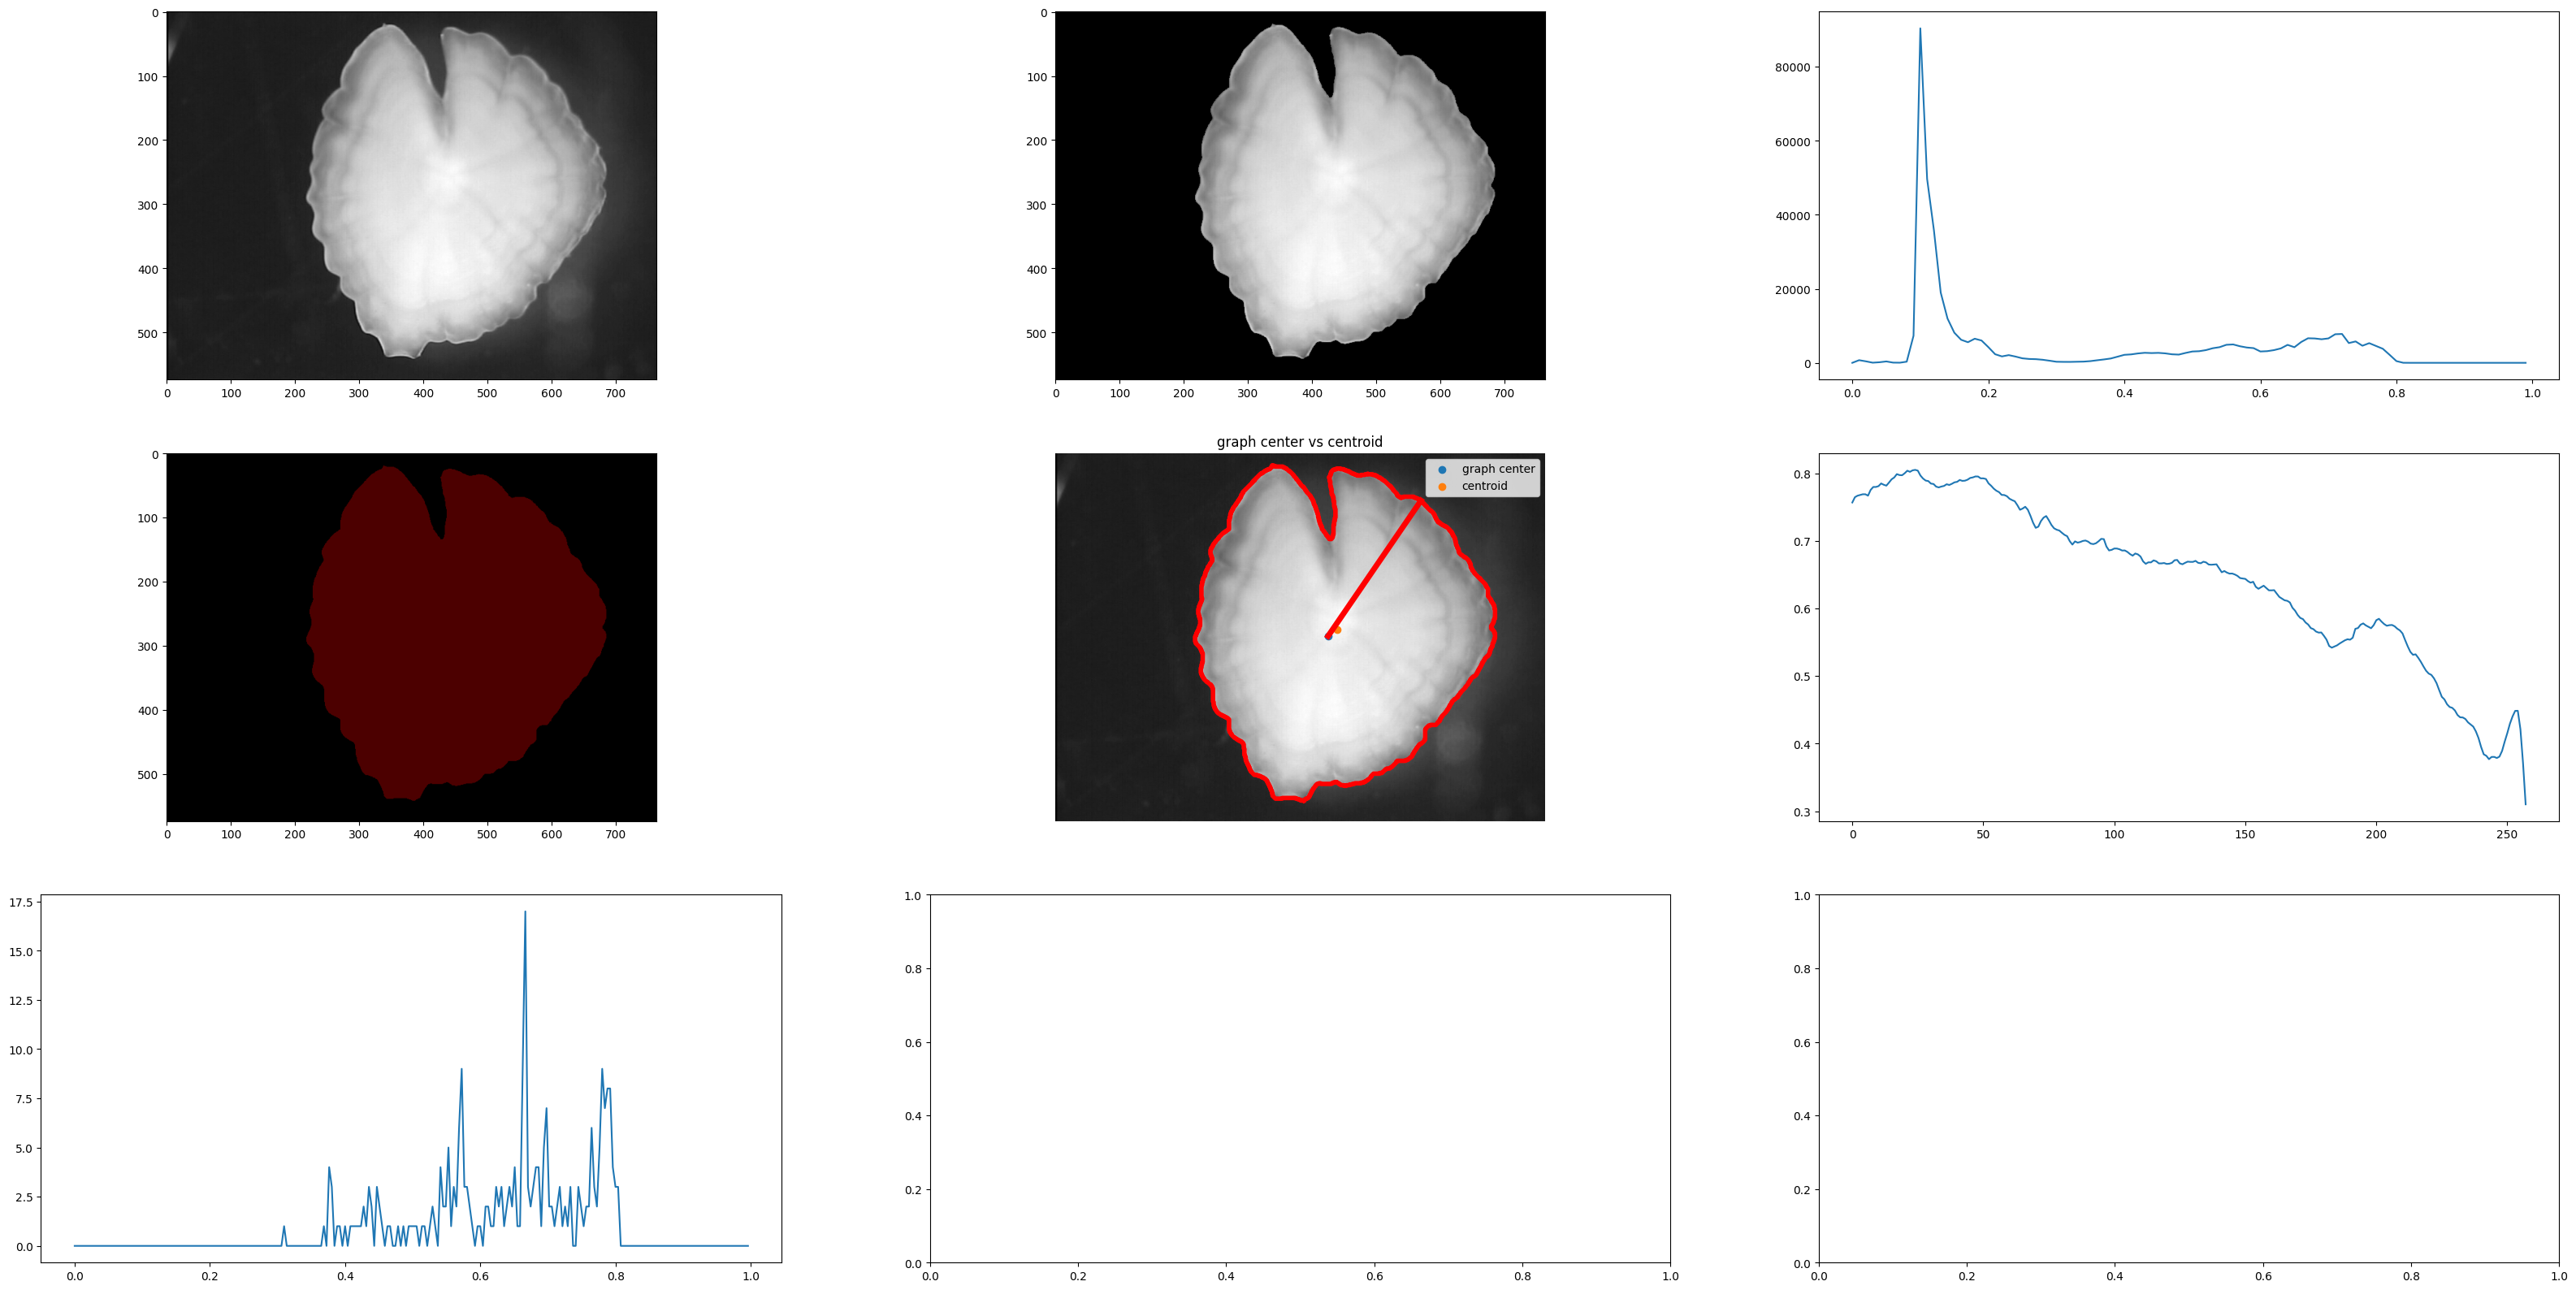

In [121]:
processador(io.imread(('photos/bios/'+dados['file'][300])), True)

In [ ]:
processador(io.imread('photos/cobaia.jpeg'))

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
http://olgahernand.free.fr/gallery_scripts/html/figure_python/von_Bertalanffy_plots.html

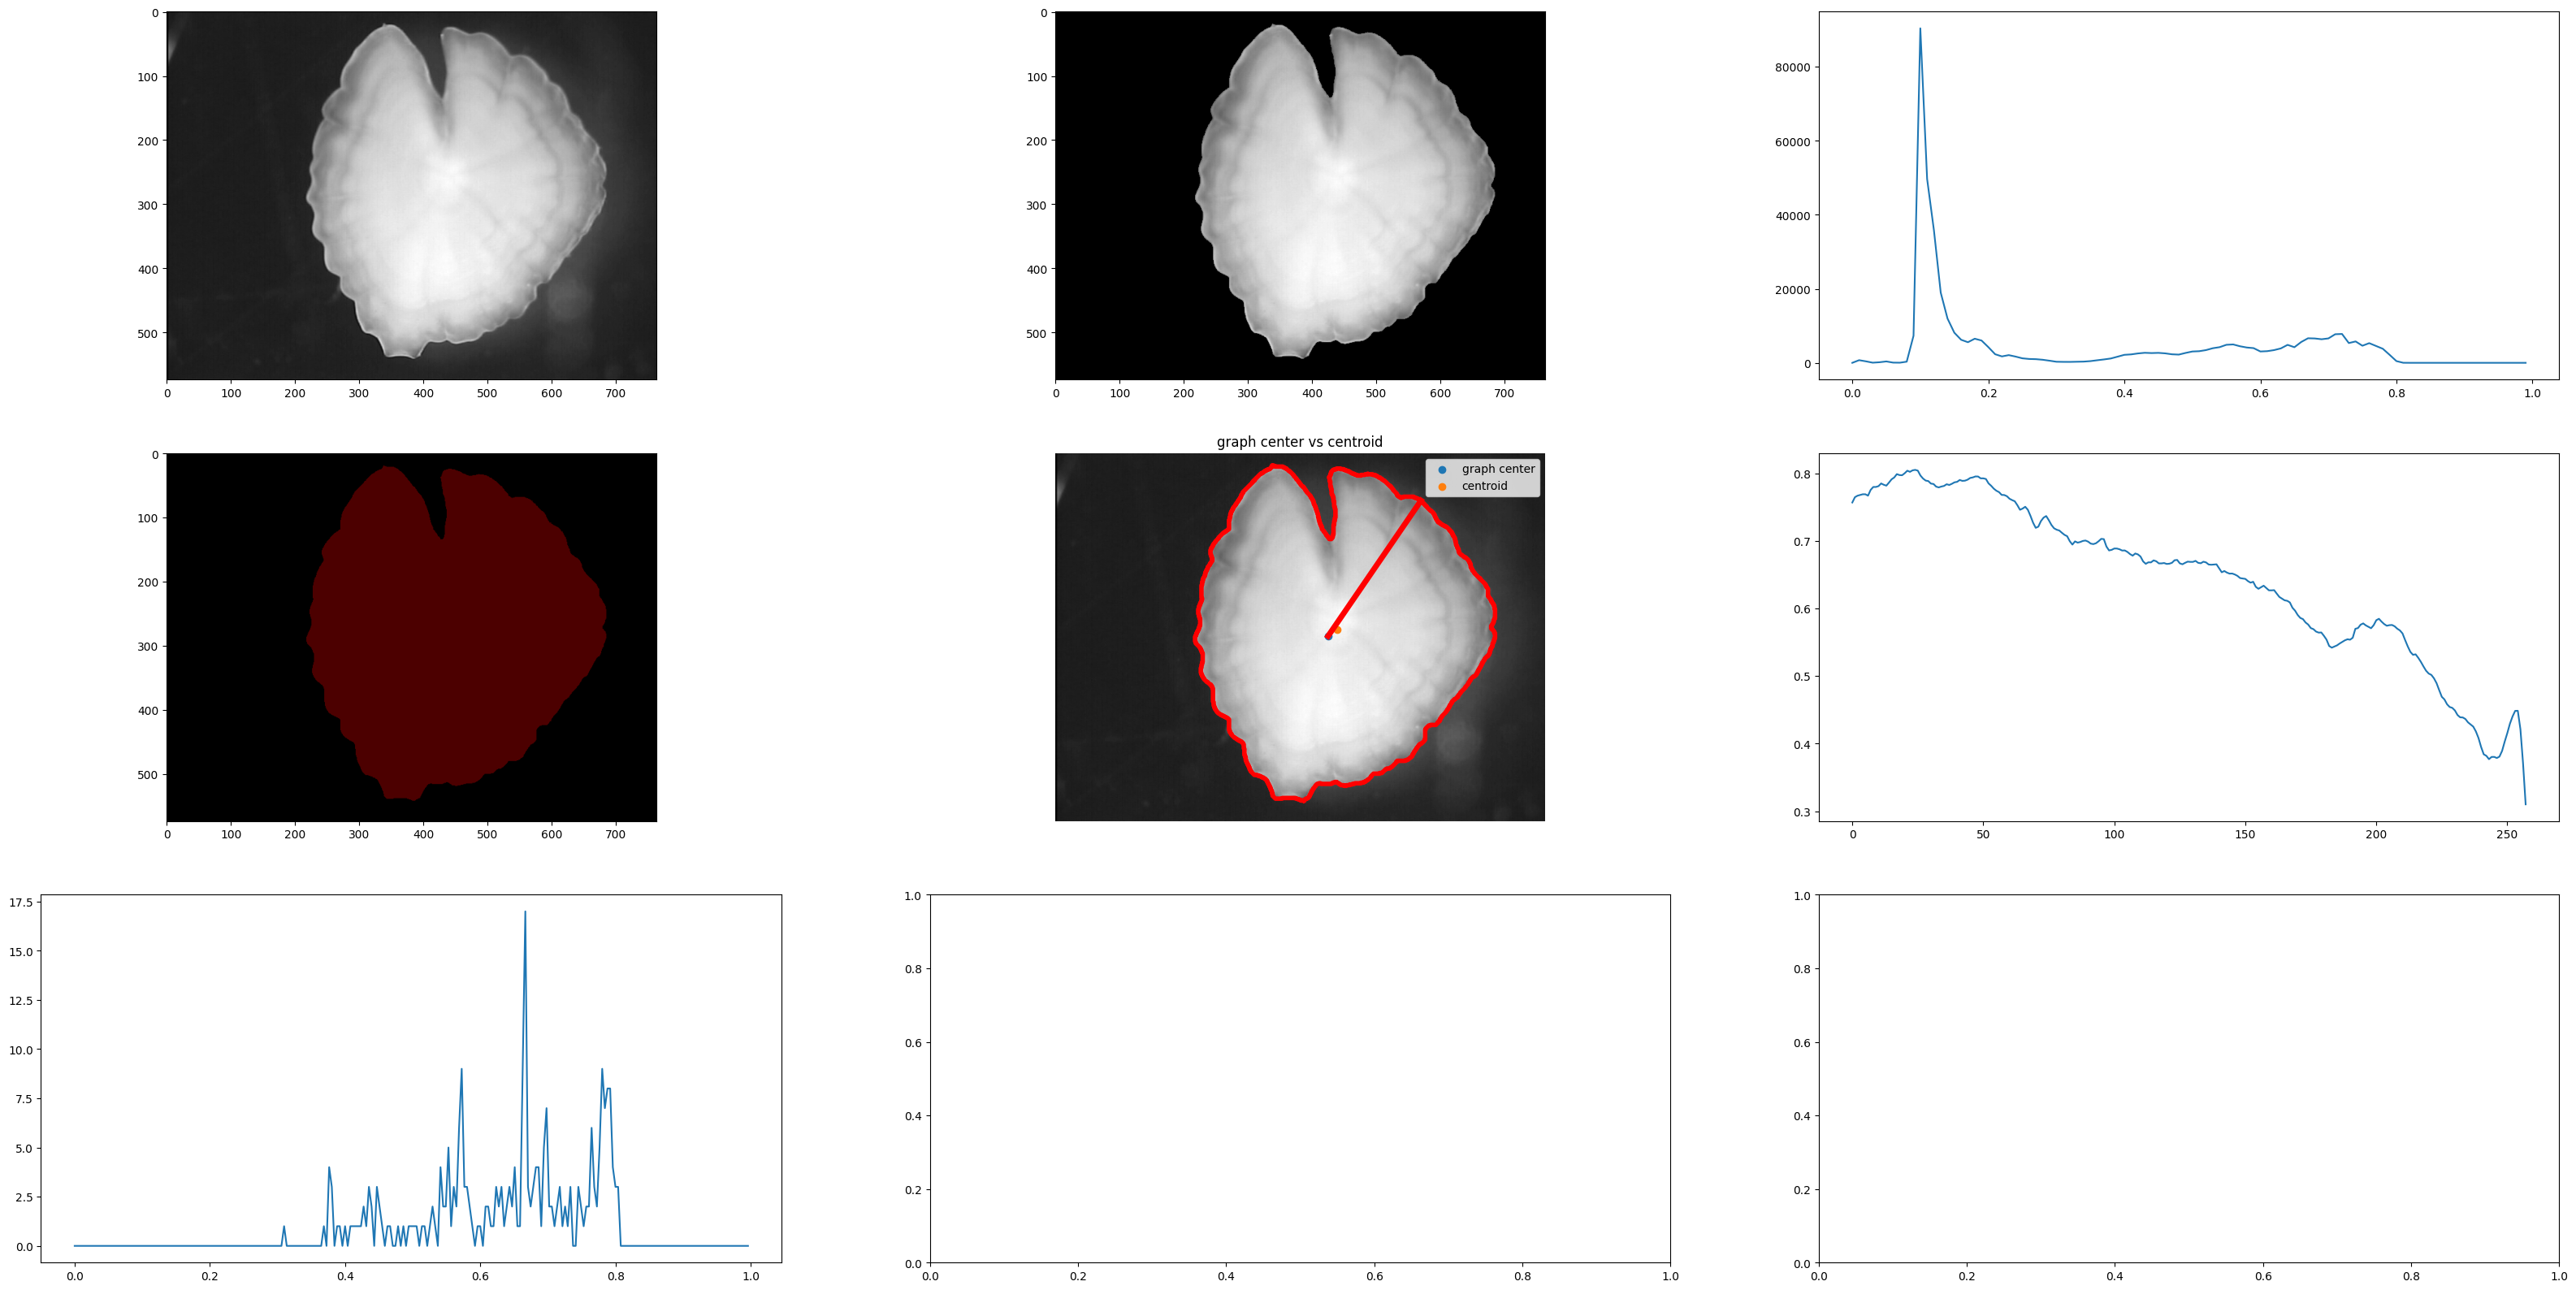

In [124]:
temp = processador(io.imread(('photos/bios/'+dados['file'][300])), True)

In [185]:
# smooth do perfil:
def suavizador(perfil:list, h=3):
    res = np.convolve(perfil, np.ones(h), "valid")/h
    return res

# primeira derivada
def deriv_1(perfil):
    res = []
    for i in range(1,np.shape(perfil)[0]-1):
        res.append((perfil[i+1] - perfil[i-1])/2)
    trans = [np.sign(i) for i in res]
    return res # antes tinha aqui trans

def deriv_2(perfil):
    res = []
    for i in range(2,np.shape(perfil)[0]-2):
        res.append((perfil[i] + perfil[i+1] - perfil[i-1] - perfil[i-2])/4)
    trans = [np.sign(i) for i in res]
    return trans

def deriv_3(perfil):
    res = []
    for i in range(3,np.shape(perfil)[0]-3):
        res.append((perfil[i] + perfil[i+1] + perfil[i+2] - perfil[i-1] - perfil[i-2] - perfil[i-3])/4)
    trans = [np.sign(i) for i in res]
    return trans

def conta_transicoes(trans:list):
    trans_b = []
    for i in range(1, np.shape(trans)[0]-1):
        if trans[i+1] > 0 and trans[i] < 0:
            trans_b.append('H -> O')
        elif trans[i+1] < 0 and trans[i] > 0:
            trans_b.append('O -> H')
    return trans_b

estimativa = conta_transicoes(deriv_1(suavizador(temp,21)))

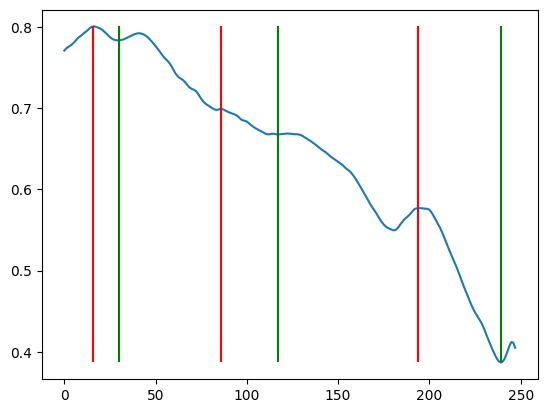

In [220]:
#y = deriv_3(temp)

#plt.plot(deriv_1(temp))
#plt.plot(deriv_1(suavizador(temp,21)), color = 'r')

temp_s = suavizador(temp,11)

picos = scipy.signal.find_peaks(temp_s, distance = 70) # manipular distance e width
vales = scipy.signal.find_peaks(temp_s*-1, distance = 70)

plt.plot(temp_s)
for pico in picos[0]:
    plt.vlines(x = pico, ymin = temp_s.min(), ymax= temp_s.max(), color = 'r')
for vale in vales[0]:
    plt.vlines(x = vale, ymin = temp_s.min(), ymax= temp_s.max(), color = 'g')

In [97]:
import heapq
heapq.nlargest(2, range(len(temp[1])), key=temp[1].__getitem__)
from scipy.signal import argrelextrema, argrelmax

In [100]:
#argrelextrema(temp[1], np.greater)
#argrelmax(temp[1])

(array([ 1,  6, 12, 27, 30, 46, 54, 59, 62, 64, 66, 69, 72, 74],
       dtype=int64),)

Validaçao e modelo de crescimento

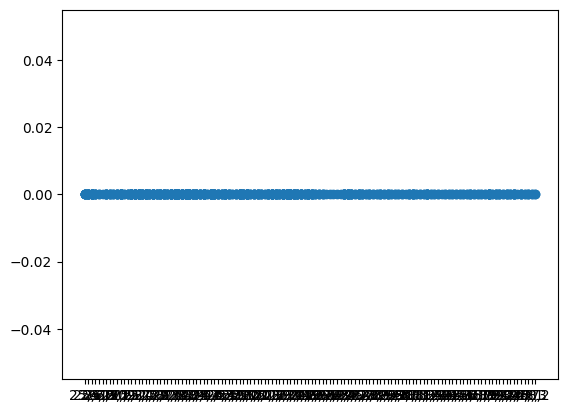

In [74]:
plt.scatter(dados['Lt'], dados['age'])

In [69]:
vonbertalanffy()

Object `vonbertalanffy()` not found.
